In [297]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

In [298]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score,precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [299]:
import src.dax_utils as utils

In [300]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [301]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [302]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .05

### Read in artifacts

In [303]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

In [304]:
X_train.shape

(3204, 2014)

In [305]:
y_train.value_counts(normalize=True)

target
0        0.58
1        0.42
Name: proportion, dtype: float64

### Baseline model

In [306]:
xgb_model = xgb.XGBClassifier(N_estimators=1200, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(N_estimators=1200, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [307]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [308]:
def find_optimal_threshold_open(y_true, y_prob):
    thresholds = np.linspace(0, 1, 1000)
    
    results = {
        'threshold': [],
        'f1_score': [],
        'recall_score': [],
        'precision_score': [],
        'TN': [],
        'FN': [],
        'TP': [],
        'FP': []
    }
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        _f1_score = f1_score(y_true, y_pred)
        _recall_score = recall_score(y_true, y_pred)
        _precision_score = precision_score(y_true, y_pred)
        
        CM = confusion_matrix(y_true, y_pred)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        
        results['threshold'].append(threshold)
        results['f1_score'].append(_f1_score)
        results['recall_score'].append(_recall_score)
        results['precision_score'].append(_precision_score)
        results['TN'].append(TN)
        results['FN'].append(FN)
        results['TP'].append(TP)
        results['FP'].append(FP)
    
    return pd.DataFrame(results)

In [309]:
thresholds = find_optimal_threshold_open((y_test == 1).astype(int), y_prob[:,1])

<Axes: >

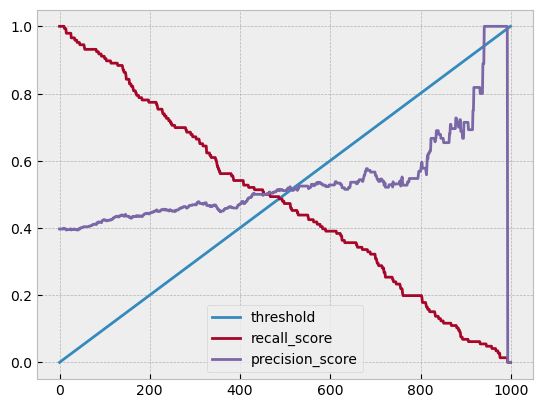

In [310]:
thresholds.loc[:, ['threshold', 'recall_score', 'precision_score']].plot()

In [311]:
# thresholds.loc[thresholds.FP == 0].sort_values('recall_score', ascending=False).head(1)
thresholds.loc[thresholds.precision_score > 0.7].sort_values('recall_score', ascending=False).head(1)

,threshold,f1_score,recall_score,precision_score,TN,FN,TP,FP
866,0.87,0.20,0.12,0.71,215,129,17,7


In [312]:
thresholds.loc[thresholds.f1_score == thresholds.f1_score.max()]

,threshold,f1_score,recall_score,precision_score,TN,FN,TP,FP
138,0.14,0.59,0.88,0.44,57,17,129,165
139,0.14,0.59,0.88,0.44,57,17,129,165


In [313]:
# thresholds.loc[thresholds.FP == 0].sort_values('recall_score', ascending=False).head(1)
thresholds.sort_values('f1_score', ascending=False).head(3)

,threshold,f1_score,recall_score,precision_score,TN,FN,TP,FP
138,0.14,0.59,0.88,0.44,57,17,129,165
139,0.14,0.59,0.88,0.44,57,17,129,165
137,0.14,0.59,0.88,0.44,56,17,129,166


In [314]:
optimal_threshold

(0.5115115115115115, 0.5944094779711218)

In [315]:
optimal_threshold = (0.51, np.nan)

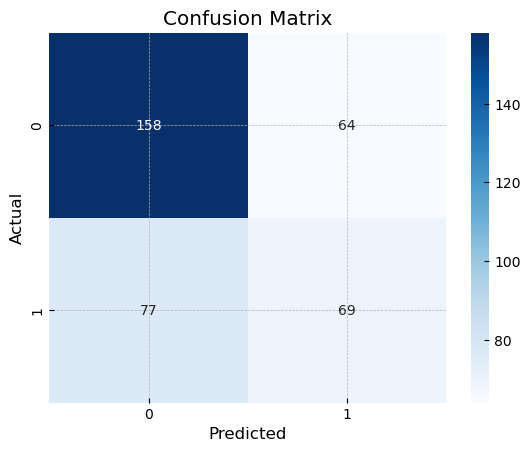

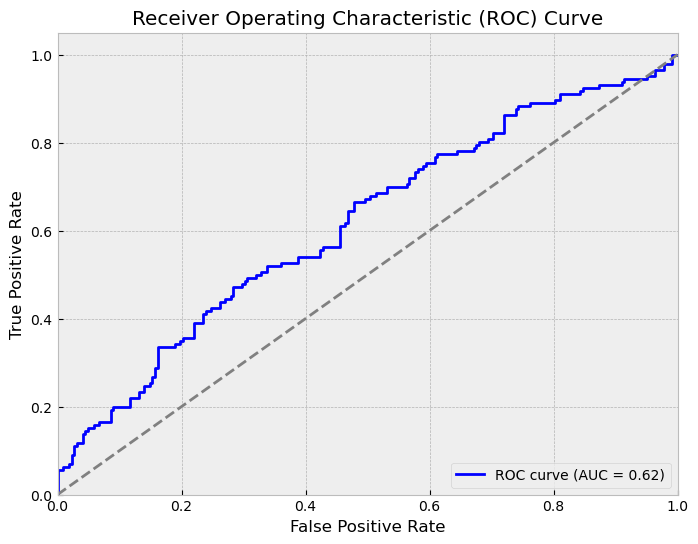

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       222
           1       0.52      0.47      0.49       146

    accuracy                           0.62       368
   macro avg       0.60      0.59      0.59       368
weighted avg       0.61      0.62      0.61       368



In [316]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

In [317]:
X_train.shape

(3204, 2014)

Lasso selection

In [318]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))
sel_.fit(X_train, y_train)
X_train = X_train[X_train.columns[sel_.get_support()]]
X_test = X_test[X_test.columns[sel_.get_support()]]
X_train.shape

(3204, 929)

Logistic regressions's p values

In [319]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()
number_of_significant_features = (results.pvalues < .05).sum() # 42
number_of_significant_features
X_train = X_train[[c for c in X_train.columns if c in results.pvalues[results.pvalues < .05]]]
X_test = X_test[[c for c in X_train.columns if c in results.pvalues[results.pvalues < .05]]]
X_train.shape

Optimization terminated successfully.
         Current function value: 0.319580
         Iterations 15


(3204, 264)

Permutation Feature Importance

In [320]:
from sklearn.inspection import permutation_importance
model = lgbm.LGBMClassifier(random_state=42, verbosity=-1)
model.fit(X_train, y_train)
r = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=0)
X_train = X_train[X_train.columns[r.importances_mean != 0]]
X_test = X_test[X_test.columns[r.importances_mean != 0]]
X_train.shape

(3204, 28)

Backward Selection

In [321]:
rfe = RFE(xgb_model, n_features_to_select=int(X_train.shape[1] / 2))
rfe.fit(X_train, y_train)
X_train = X_train[X_train.columns[rfe.support_]]
X_test = X_test[X_test.columns[rfe.support_]]
X_train.shape

(3204, 14)

Forward Selection

In [322]:
from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import precision_score, f1_score, make_scorer
from xgboost import XGBClassifier
import lightgbm as lgbm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [324]:
clf = lgbm.LGBMClassifier(random_state=42)
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=4)

# Build step forward feature selection
sfs1 = sfs(clf, 
           k_features=int(X_train.shape[1] / 2), # int(X_train.shape / 2)
           forward=True,
           floating=False,
           verbose=2,
           scoring=make_scorer(f1_score, greater_is_better=True),  # Use the custom scorer
           cv=timeseries_splitter,
           n_jobs=-1)

In [325]:
sfs1.fit(X_train, y_train)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    7.4s finished

[2024-07-27 15:53:20] Features: 1/7 -- score: 0.4269005935692354[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    1.0s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    1.3s finished

[2024-07-27 15:53:21] Features: 2/7 -- score: 0.4840598270457337[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished

[2024-07-27 15:53:23

[2, 4, 6, 7, 8, 10, 13]


[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished

[2024-07-27 15:53:26] Features: 7/7 -- score: 0.5131116539018838

In [326]:
# feat_cols =  [27, 58, 61, 64, 74, 80, 82, 97, 121, 122, 139, 189, 198, 206, 209, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 246, 286, 287, 328, 364, 376, 425, 441, 456, 459, 467, 495, 503, 510, 518, 562, 565, 604, 636, 645, 646]

In [327]:
X_train.columns[feat_cols]

Index(['sunrise_dusk close_gdaxi_spy_corr10d',
       'close_ief_spy_corr30d close_gdaxi_vol5d',
       'close_spy_gld_corr10d low_gdaxi_low_vol5d',
       'close_gdaxi_gld_corr10d low_gdaxi_low_vol3d',
       'close_gdaxi_gld_corr10d year_days_passed',
       'close_ief_gld_corr30d year_days_passed',
       'close_spy_gld_corr30d close_ief_gld_corr10d'],
      dtype='object')

In [328]:
X_train = X_train[X_train.columns[feat_cols]]
X_test = X_test[X_test.columns[feat_cols]]

In [329]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [330]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

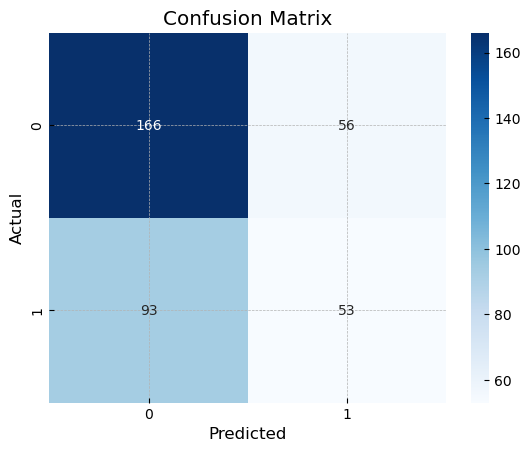

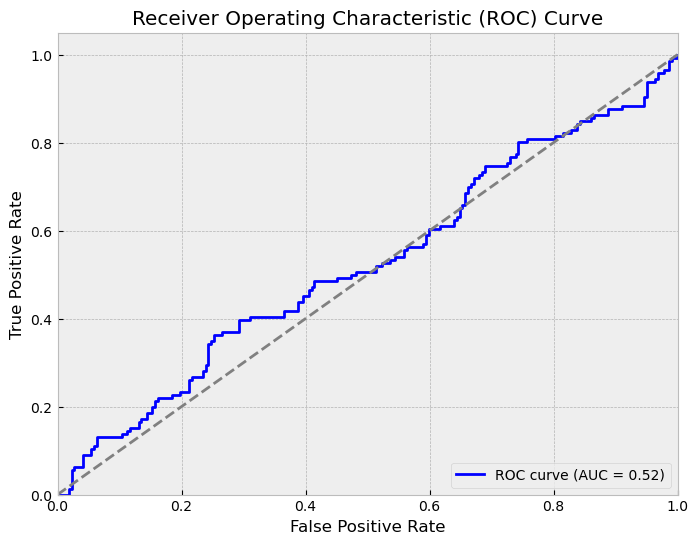

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       222
           1       0.49      0.36      0.42       146

    accuracy                           0.60       368
   macro avg       0.56      0.56      0.55       368
weighted avg       0.58      0.60      0.58       368



In [331]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [332]:
import shap

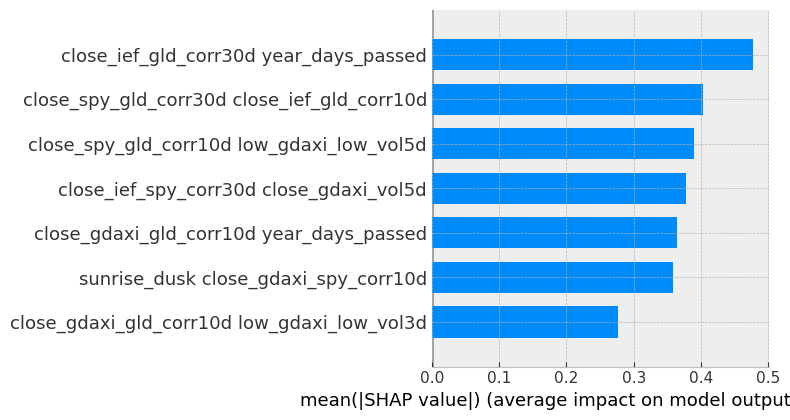

In [333]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [ ]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [ ]:
# scores = list()
# timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)

# for train_index, test_index in timeseries_splitter.split(X_train):
#     # print("TRAIN:", len(train_index), "TEST:", len(test_index))
#     xgb_model = xgb.XGBClassifier(random_state=42)
#     xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
#     scores.append(
#         roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
#     )

In [ ]:
# baseline_score = np.array(scores).mean()
# baseline_score

In [ ]:
import importlib
importlib.reload(utils)

In [ ]:
# del RFE_FEATURES; del _RFE_FEATURES

In [ ]:
# X_train.columns.shape[0]

In [ ]:
# big_step, small_step = 3, 1
# timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=6)
# number_of_features = X_train.columns.shape[0] - big_step
# step = big_step
# current_score = baseline_score
# all_scores = {}

# progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

# n = 0
# while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
#     try:
#         RFE_FEATURES = _RFE_FEATURES.copy()
#     except NameError:
#         RFE_FEATURES = X_train.columns
    
#     rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
#     rfe.fit(X_train[RFE_FEATURES], y_train)
    
#     _RFE_FEATURES = X_train[RFE_FEATURES].columns[rfe.support_]
    
#     scores = list()
#     for train_index, test_index in timeseries_splitter.split(X_train):
#         # print("TRAIN:", len(train_index), "TEST:", len(test_index))
#         xgb_model = xgb.XGBClassifier(random_state=42)
#         xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

#         scores.append(
#             roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
#         )

#     current_score = np.array(scores).mean()
#     all_scores[number_of_features] = scores.copy()
    
#     if n % 5 == 0:
#         FEATURE_SELECTION_AUC_DROP_THRESHOLD = FEATURE_SELECTION_AUC_DROP_THRESHOLD - .01
#         step = step - 1
        
#     number_of_features = number_of_features - step
#     progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
#     progress_bar.update(step)
#     n += 1

# progress_bar.close()

### Test Reduced Feature Set

In [136]:
X_train.shape

(3204, 28)

In [122]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [123]:
y_prob = xgb_model.predict_proba(X_test)
# optimal_threshold = utils.Tools.find_opimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score
thresholds = find_optimal_threshold_open((y_test == 1).astype(int), y_prob[:,1])

In [127]:
thresholds.sort_values(['f1_score', 'precision_score'], ascending=False) #loc[thresholds.precision_score > 0.7].sort_values('recall_score', ascending=False).head(1)

,threshold,f1_score,recall_score,precision_score,TN,FN,TP,FP
66,0.07,0.57,0.98,0.41,13,3,143,209
64,0.06,0.57,0.98,0.41,12,3,143,210
65,0.07,0.57,0.98,0.41,12,3,143,210
61,0.06,0.57,0.98,0.40,11,3,143,211
62,0.06,0.57,0.98,0.40,11,3,143,211
...,...,...,...,...,...,...,...,...
995,1.00,0.00,0.00,0.00,222,146,0,0
996,1.00,0.00,0.00,0.00,222,146,0,0
997,1.00,0.00,0.00,0.00,222,146,0,0
998,1.00,0.00,0.00,0.00,222,146,0,0


In [133]:
optimal_threshold = (.5, np.nan)

<Axes: >

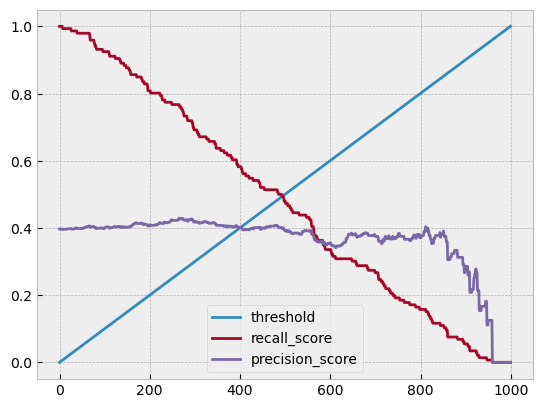

In [135]:
thresholds.loc[:, ['threshold', 'recall_score', 'precision_score']].plot()

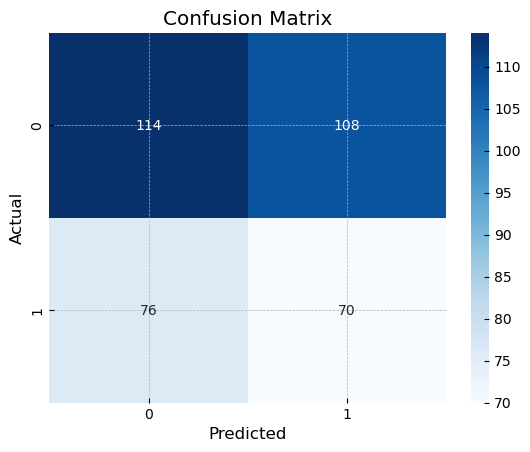

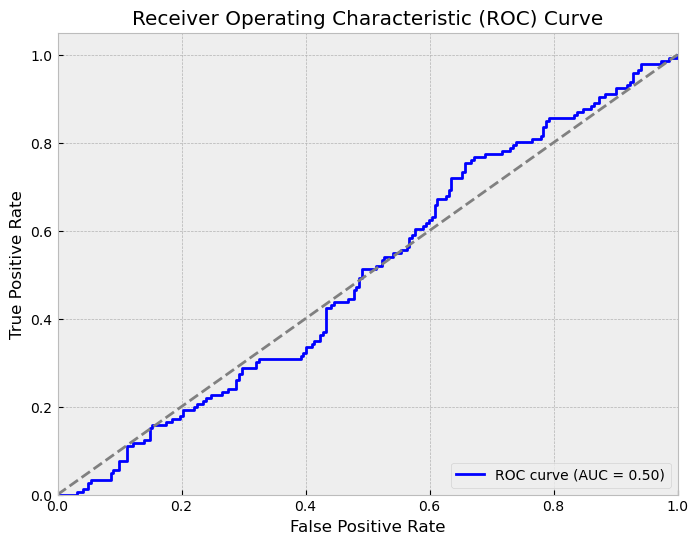

              precision    recall  f1-score   support

           0       0.60      0.51      0.55       222
           1       0.39      0.48      0.43       146

    accuracy                           0.50       368
   macro avg       0.50      0.50      0.49       368
weighted avg       0.52      0.50      0.51       368



In [134]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [ ]:
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

### Hyperparam optimization

In [ ]:
def objective_xgboost_classification(X_train, y_train, trial):

    # _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    # _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 2000),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }
    
    steps = 5
    timeseries_splitter = ReasonableTimeSeriesSplit(n_splits=steps)
    scores = np.empty(steps)
    
    for idx, (train_index, test_index) in enumerate(timeseries_splitter.split(X_train)):
        xgb_model = xgb.XGBClassifier(**params, random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
        scores[idx] = roc_auc_score(y_train.iloc[test_index], 
                                    xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])

    
    # Initialize the XGBoost classifier model with hyperparameters
    # model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    # model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    # y_pred_proba = model.predict_proba(X_valid)[:, 1]
    # score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return scores.mean()

In [ ]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train.loc[:,RFE_FEATURES], y_train)
study_xgboost_classification.optimize(objective, n_trials=400)

In [ ]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best parameters

In [ ]:
RFE_FEATURES

In [ ]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

In [ ]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [ ]:
os.makedirs('../config', exist_ok=True)
    
config = {
    'selected_features' : list(RFE_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

In [ ]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [ ]:
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")